# EMG Data Processing
- In this notebook, the EMG data from the 1022102cFnorm.csv is used to perform XGBoost analysis.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization (e.g plot graphs)
import seaborn as sns #  creates informative statistical graphics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf # building and training neural networks
import xgboost as xgb # for building and training neural networks
from digital_processing import bp_filter, notch_filter, plot_signal
from feature_extraction import features_estimation
import os
from xgboost import plot_importance
import neurokit2 as nk
import datetime as dt

### Loading data

In [5]:
data = pd.read_csv('../data/p1_w1/1022102cFnorm.csv')
loc = pd.read_csv('../data/p1_w1/1022102clocation_Bites.csv')

# print(df.head())
print(data.shape, loc.shape)
# print(df.describe)

data.describe() # describes the data

(74155516, 8) (3, 4)


,MR,ML,SU,Microphone,Eye,ECG,Pressure Sensor,Unnamed: 7
count,7.415552e+07,7.415552e+07,7.415552e+07,7.415552e+07,7.415552e+07,7.415552e+07,0.0,0.0
mean,1.855184e-09,7.241122e-10,3.478219e-09,-3.646050e-04,-5.591801e-04,6.660682e-04,NaN,NaN
std,1.000000e+00,1.000000e+00,9.999999e-01,1.513202e-04,1.506343e-02,5.071496e-03,NaN,NaN
min,-4.477700e+02,-7.358500e+02,-2.108400e+02,-1.562600e-01,-6.958700e-01,-3.078000e-02,NaN,NaN
25%,-1.388700e-02,-3.572300e-02,-1.006900e-01,-3.746700e-04,-1.203100e-03,-2.982600e-04,NaN,NaN
50%,-9.943550e-05,1.838600e-04,-1.034700e-04,-3.552400e-04,-5.472900e-04,3.526200e-04,NaN,NaN
75%,1.370000e-02,3.560900e-02,1.001400e-01,-3.382000e-04,4.458400e-05,1.104100e-03,NaN,NaN
max,2.822900e+02,5.069800e+02,2.581800e+02,3.022800e-01,7.554900e-01,2.457000e-01,NaN,NaN


### Resampling

In [6]:
org_freq = 2000
tgt_freq = 1000
dsample_rate = np.round(org_freq / tgt_freq).astype("int")

# df = nk.signal_resample(data.copy(), sampling_rate=org_freq, desired_sampling_rate=tgt_freq, method="pandas")
df = data.iloc[::dsample_rate, :].copy()
print(df.shape)
df.describe()

(37077758, 8)


,MR,ML,SU,Microphone,Eye,ECG,Pressure Sensor,Unnamed: 7
count,3.707776e+07,3.707776e+07,3.707776e+07,3.707776e+07,3.707776e+07,3.707776e+07,0.0,0.0
mean,1.026545e-09,-1.803854e-09,1.063062e-08,-3.645998e-04,-5.591799e-04,6.660691e-04,NaN,NaN
std,9.999740e-01,9.999532e-01,9.999966e-01,1.514262e-04,1.506342e-02,5.071532e-03,NaN,NaN
min,-4.477700e+02,-7.358500e+02,-2.006100e+02,-1.562600e-01,-6.956700e-01,-3.078000e-02,NaN,NaN
25%,-1.388600e-02,-3.572500e-02,-1.007000e-01,-3.746700e-04,-1.203100e-03,-2.982600e-04,NaN,NaN
50%,-9.912750e-05,1.841000e-04,-1.034650e-04,-3.552400e-04,-5.472900e-04,3.526200e-04,NaN,NaN
75%,1.370200e-02,3.561300e-02,1.001400e-01,-3.382000e-04,4.458400e-05,1.104100e-03,NaN,NaN
max,2.822900e+02,5.069800e+02,2.581800e+02,2.881800e-01,7.554900e-01,2.457000e-01,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37077758 entries, 0 to 74155514
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   MR               float64
 1   ML               float64
 2   SU               float64
 3   Microphone       float64
 4   Eye              float64
 5   ECG              float64
 6   Pressure Sensor  float64
 7   Unnamed: 7       float64
dtypes: float64(8)
memory usage: 2.2 GB


### Visualization of the normalized data

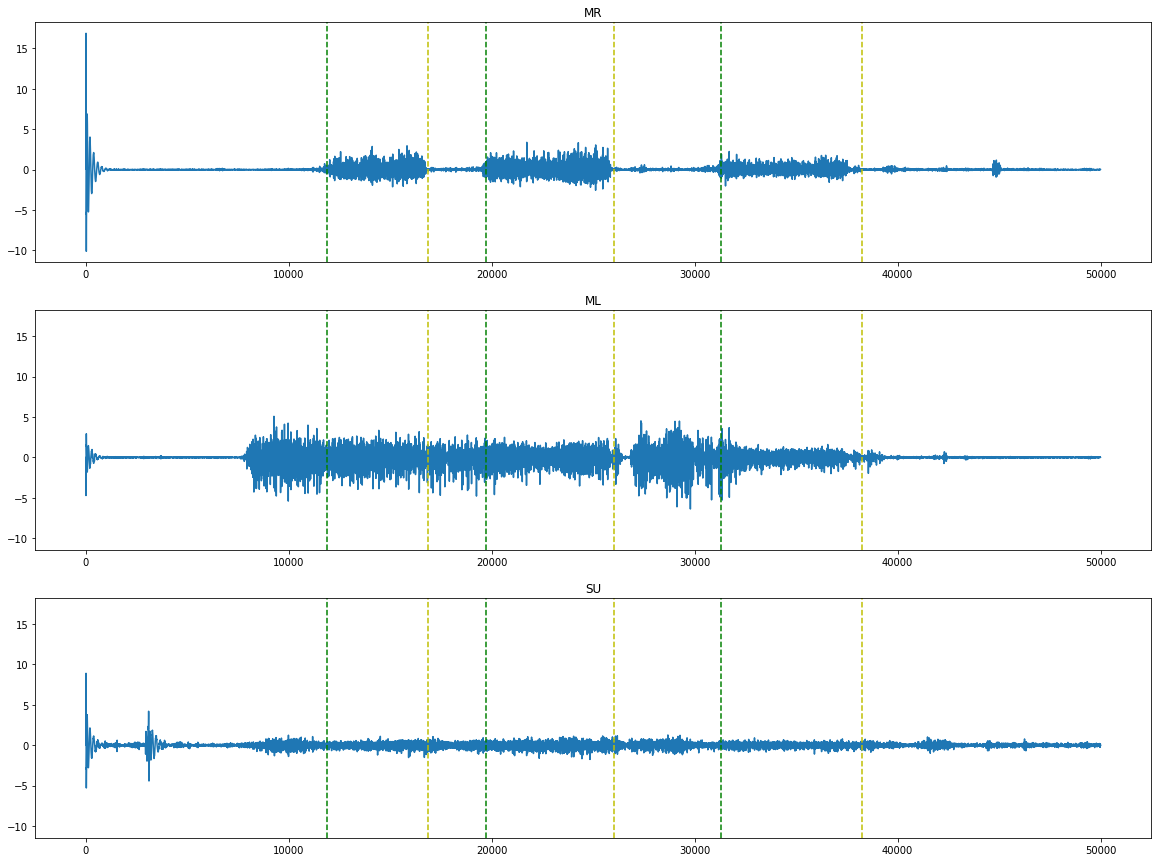

In [7]:
range_min = 0
range_max = 25000
def plot_data(data, loc):    
    fig, axes = plt.subplots(3,1, figsize=(20, 15), sharey=True) # ensures that all subplots share the same x-axis and y-axis
    for i in range(3):
        axes[i].plot(data.iloc[range_min:range_max,i])
        axes[i].set_title(data.columns[i])
        for j in range(loc.shape[0]):
            axes[i].axvline(x=loc.iloc[j,0], color='g', linestyle='--')
            axes[i].axvline(x=loc.iloc[j,1], color='y', linestyle='--')
        
plot_data(df, loc)

### Data Preprocessing

In [8]:
range_min = 0
range_max = 25000

bites = np.zeros(data.shape[0], dtype=int)
for i in range(1, range_max*dsample_rate):
    if i < loc.iloc[0,0] or (i > loc.iloc[0,1] and i < loc.iloc[1,0]) or (i > loc.iloc[1,1] and i < loc.iloc[2,0]) or i > loc.iloc[2,1]:
        bites[i] = 0
    else:
        bites[i] = 1

df.loc[:,'Bites'] = bites[::dsample_rate]
x = df.iloc[range_min:range_max,:2].copy()
y = df.iloc[range_min:range_max,-1].copy()
print(x.shape)
print(y.shape)

(25000, 2)
(25000,)


In [9]:
x = np.array(x.values.tolist())
y = np.array(y.values.tolist())

### Sliding window

In [72]:
window_size = 1000  # Size of the sliding window
stride = 50  # Stride or step size between windows
channel = 0  # Channel to be used for training

# Generate sliding window subsequences
windows = []
labels = []
for i in range(0, len(x) - window_size + 1, stride):
    window = x.iloc[i:i+window_size, channel].copy()
    windows.append(window)
    labels.append(1 if np.mean(y.iloc[i:i+window_size-1])>=0.5 else 0)

# Convert to numpy arrays
windows = np.array(windows)
labels = np.array(labels)
# windows = pd.concat(windows)
# labels = pd.Series(labels)

# Flatten the windows to match the input shape of XGBoost
flattened_windows = windows.reshape(windows.shape[0], -1)
print(flattened_windows.shape)


(481, 1000)


In [73]:
x_train, x_test, y_train, y_test = train_test_split(flattened_windows, labels, test_size=0.2, random_state=0) # Split data for test and training

SC = StandardScaler()
x_train = pd.DataFrame(SC.fit_transform(x_train))
x_test = pd.DataFrame(SC.transform(x_test))

### Split dataset

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25) # Split data for test and training

SC = StandardScaler()
x_train = pd.DataFrame(SC.fit_transform(x_train))
x_test = pd.DataFrame(SC.transform(x_test))

### Get Best parameters

In [51]:
params = {
    "max_depth" : [3, 5, 7],
    "max_leaf_nodes" : [15, 20, 25]
}

model1 = DTC()
clf = GridSearchCV(model1, params, scoring = "accuracy", cv=5)

clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'max_leaf_nodes': [15, 20, 25]},
             scoring='accuracy')

In [52]:
res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Parameters:{'max_depth': 3, 'max_leaf_nodes': 15} Mean_score: 0.8459200000000001 Rank: 7
Parameters:{'max_depth': 3, 'max_leaf_nodes': 20} Mean_score: 0.8459200000000001 Rank: 7
Parameters:{'max_depth': 3, 'max_leaf_nodes': 25} Mean_score: 0.8459200000000001 Rank: 7
Parameters:{'max_depth': 5, 'max_leaf_nodes': 15} Mean_score: 0.8480000000000001 Rank: 5
Parameters:{'max_depth': 5, 'max_leaf_nodes': 20} Mean_score: 0.8490133333333333 Rank: 2
Parameters:{'max_depth': 5, 'max_leaf_nodes': 25} Mean_score: 0.8504533333333333 Rank: 1
Parameters:{'max_depth': 7, 'max_leaf_nodes': 15} Mean_score: 0.8476266666666668 Rank: 6
Parameters:{'max_depth': 7, 'max_leaf_nodes': 20} Mean_score: 0.84848 Rank: 4
Parameters:{'max_depth': 7, 'max_leaf_nodes': 25} Mean_score: 0.8486933333333333 Rank: 3


In [53]:
print(clf.best_estimator_)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=25)


In [54]:
def plot_learning_curve(estimator, x, y, title):

  train_sizes, train_scores, test_scores, _, _ = learning_curve(estimator,
    x, y, return_times=True)

  fig, axes = plt.subplots(1, 1, figsize = (10, 5))

  axes.set_title(title)
  axes.plot
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")


  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  axes.grid()
  axes.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color="r",
  )
  axes.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",
  )
  axes.plot(
      train_sizes, train_scores_mean, "o-", color="r", label="Training score"
  )
  axes.plot(
      train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
  )
  axes.legend(loc="best")

  plt.show()

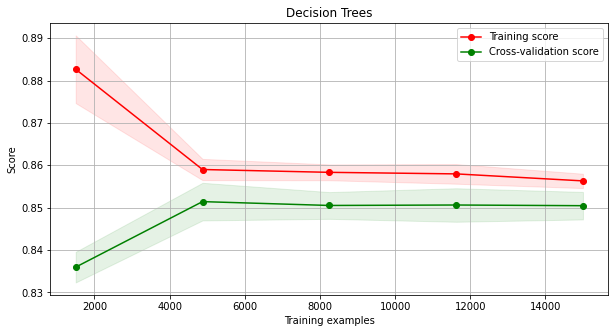

0.85584


In [55]:
model1 = clf.best_estimator_

model1.fit(x_train, y_train)

plot_learning_curve(model1, x_train, y_train, "Decision Trees")

print(model1.score(x_train, y_train))

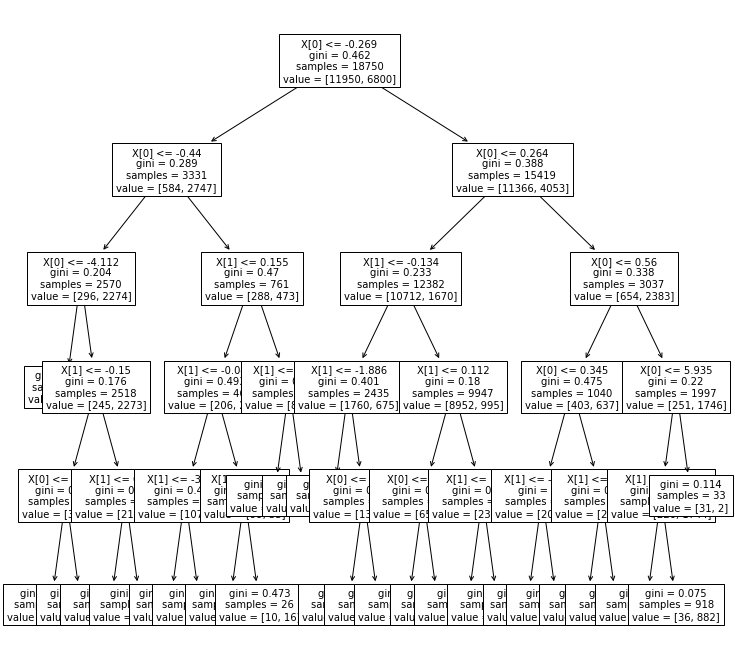

In [56]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(model1, fontsize=10)
plt.show()

In [57]:
params = {
        'learning_rate': [0.1, 0.5, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model_XGB = xgb.XGBClassifier(n_estimators=100, objective='multi:softmax', num_class=20, silent=False) #100 base learners, for multiclass- log loss does not work. need softmax
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(model_XGB, param_distributions=params, n_iter=10, scoring='accuracy', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001 )

# number of iterations=10, n_jobs=4= it will try to distribute it across 4 cores

start = dt.datetime.now()
random_search.fit(x_train, y_train)
end = dt.datetime.now()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[02:59:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:59:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:59:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:59:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/3] END colsample_bytree=0.6, learning_rate=0.8, max_depth=4, subsample=1.0;, score=0.846 total time=   1.3s
[02:59:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38

In [58]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 0.6, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


### Train whole data

In [59]:
best_xgb = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic',
    eval_metric='logloss', subsample=0.6, max_depth=3, learning_rate=0.1, colsample_bytree=1.0, silent=True)
best_xgb.fit(x_train, y_train)

[02:59:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [60]:
print(f"Time taken for training : {end - start}\nTraining accuracy:{best_xgb.score(x_train, y_train)}\nTest Accuracy: {best_xgb.score(x_test, y_test)}")

Time taken for training : 0:00:14.842894
Training accuracy:0.86176
Test Accuracy: 0.85312


[0.7842625  0.21573752]


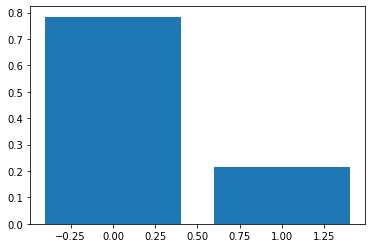

In [61]:
print(best_xgb.feature_importances_)

plt.bar(range(len(best_xgb.feature_importances_)), best_xgb.feature_importances_)
plt.show()

### Batch

In [32]:
batch_size = 1000
intervals = 100
num_batches = len(x) // batch_size
col_size = 3

model_XGB = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100
)

first = True
for i in range(1):
    for start in range(0, len(x_train), batch_size):
        if first:
            first = False
            best_xgb.fit(x_train[start:start+batch_size], y_train[start:start+batch_size])
            continue
        best_xgb.fit(x_train[start:start+batch_size], y_train[start:start+batch_size], xgb_model=best_xgb)



[02:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:16:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpytho

### Model

In [74]:
model_XGB = xgb.XGBClassifier()
model_RF = RandomForestClassifier(n_estimators = 100, random_state=0)
model_XGB.fit(x_train, y_train)
model_RF.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [75]:
y_pred = model_RF.predict(x_test)
y_p = model_XGB.predict(x_test)
accuracy = accuracy_score(y_test, [q for q in y_pred])
accuracy_p = accuracy_score(y_test, [r for r in y_p])
print("Accuracy for RF: %.2f%%" % (accuracy * 100.0))
print("Accuracy for XGB: %.2f%%" % (accuracy_p * 100.0))

Accuracy for RF: 97.94%
Accuracy for XGB: 97.94%


### Confusion Matrix

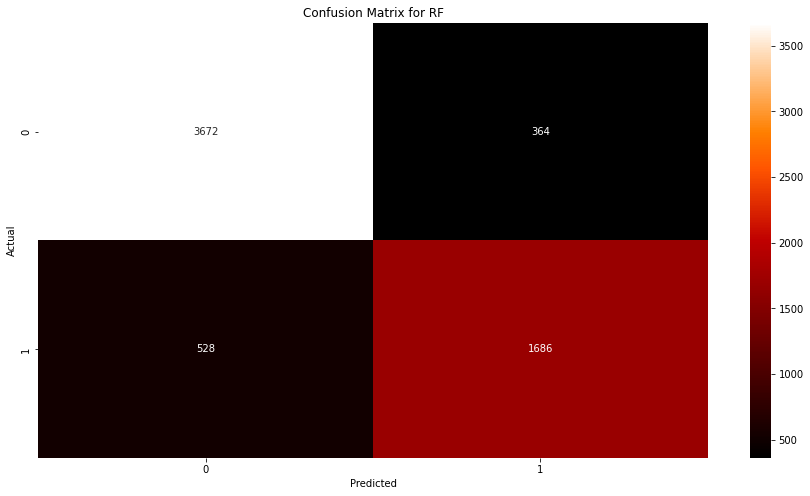

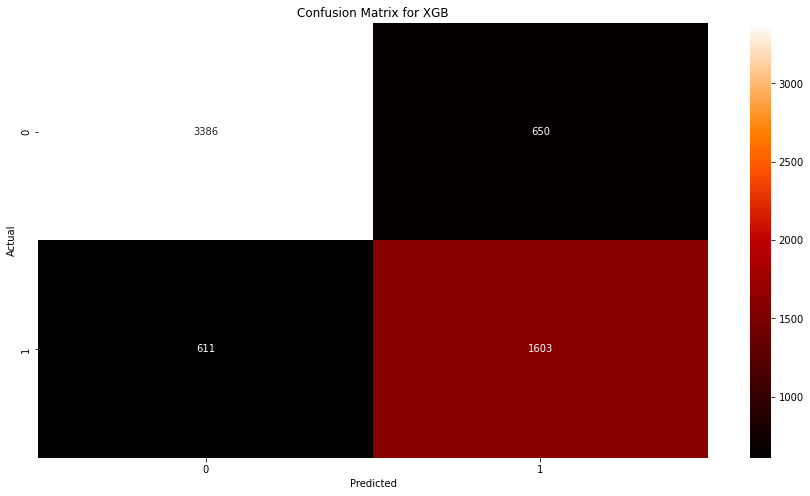

In [43]:
y_true = np.array(y_test)
y_pred = np.array(model_RF.predict(x_test))
y_pred_xgb = np.array(model_XGB.predict(x_test))

cm = confusion_matrix(y_true, y_pred)
cm_xgb = confusion_matrix(y_true, y_pred_xgb)
plt.figure(figsize = (15,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='gist_heat', cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for RF")
plt.show()
plt.figure(figsize = (15,8))
sns.heatmap(cm_xgb, annot=True, fmt='g', cmap='gist_heat',cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGB")
plt.show()

### Pick channel and Predict

['0', '1']


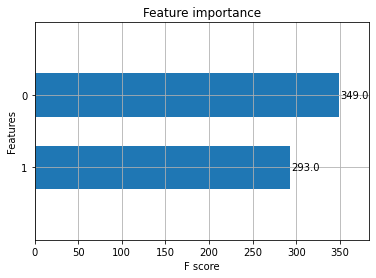

In [62]:
_ = plot_importance(best_xgb, height=0.6)
# model_XGB.get_booster().feature_names = ['EMG1', 'EMG2', 'EMG3']
print(best_xgb.get_booster().feature_names)

In [63]:
y_p = best_xgb.predict(x_test)
accuracy_p = accuracy_score(y_test, [r for r in y_p])
print("Accuracy for XGB: %.2f%%" % (accuracy_p * 100.0))

Accuracy for XGB: 85.31%


In [64]:
x_p = df.iloc[range_max:80000,:2].copy()
x_p = np.array(x_p.values.tolist())
y_p = best_xgb.predict(x_p)
print(y_p)
print(len(y_p))

[0 0 0 ... 0 1 1]
55000


In [65]:
y_p_mix = []
i =0
while i < len(y_p):
    y_sum = y_p[i];
    cnt = 1;
    for j in range(1, 1000):
        if(i+j >= len(y_p)):
            break;
        y_sum += y_p[i+j];
        cnt += 1;
    if y_sum/cnt > 0.05:
        y_p_mix.extend([1]*cnt);
    else:
        y_p_mix.extend([0]*cnt);
    i += cnt;
    # print(i)
    # print("cnt: ", cnt)
# print(y_p_mix)
print(len(y_p_mix))

55000


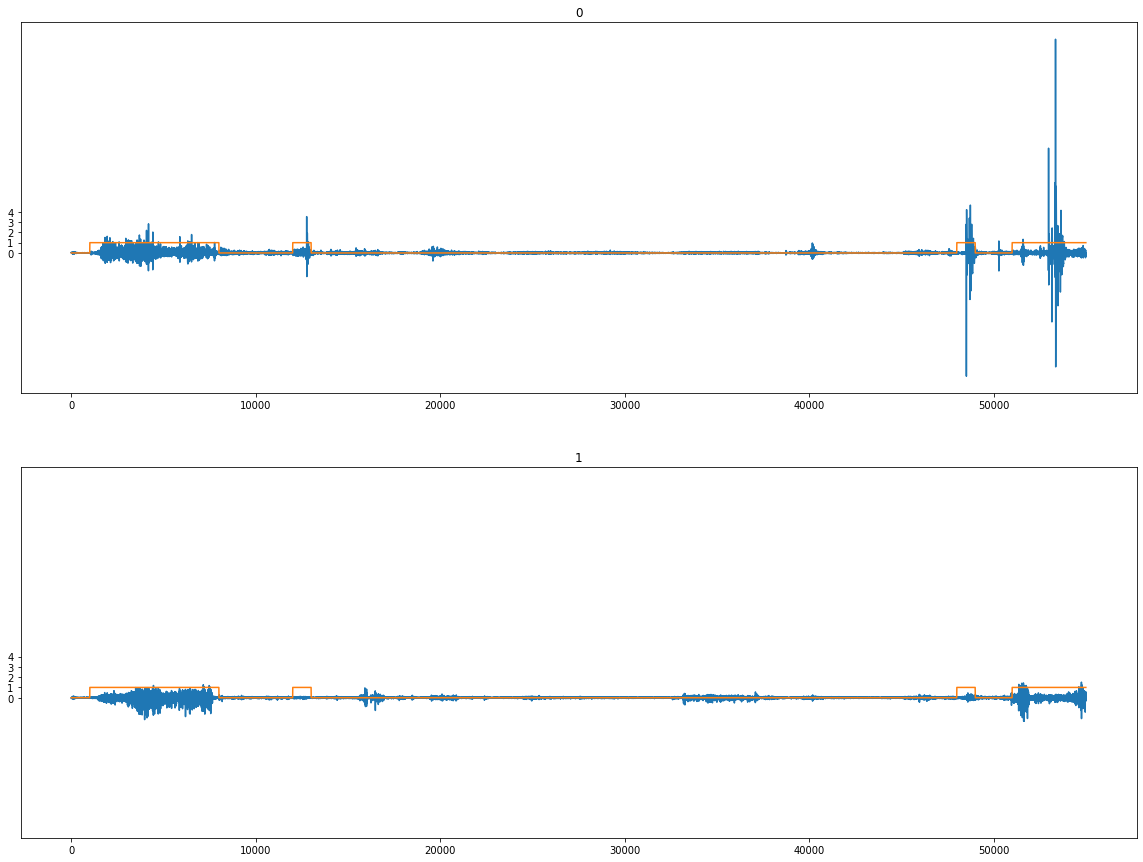

In [66]:
def plot_predict(data, pred):    
    fig, axes = plt.subplots(2,1, figsize=(20, 15), sharey=True) # ensures that all subplots share the same x-axis and y-axis
    for i in range(2):
        axes[i].plot(data[:,i])
        axes[i].plot(pred[:])
        axes[i].set_title(i)
        axes[i].yaxis.set_ticks(np.arange(0, 5, 1))
        # for j in range(loc.shape[0]):
        #     axes[i].axvline(x=loc.iloc[j,0], color='g', linestyle='--')
        #     axes[i].axvline(x=loc.iloc[j,1], color='y', linestyle='--')
        
plot_predict(x_p, y_p_mix)

In [ ]:
best_xgb.save_model("p1.json")
model2 = xgb.XGBClassifier()
model2.load_model("p1.json")